Import Necesarry Library

In [1]:
# Example grouping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from xgboost import XGBClassifier
from tpot import TPOTClassifier
import shap


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Data Preprocessing

In [37]:
# Load Data
data_path = "C:/Users/User/OneDrive - UNIVERSITAS INDONESIA/Perkuliahan/Semester 9/Tesis/Data Processing/Data/fs_data_clean.xlsx"
fs_data = pd.read_excel(data_path)

In [38]:
# Initial Data Inspection
print("First 5 rows of the dataset:")
print(fs_data.head())
print("\nDataset Information:")
print(fs_data.info())

First 5 rows of the dataset:
   kode                    nama  tahun mata_uang   kurs tanggal_listing  \
0  ADMG  Polychem Indonesia Tbk   2018       USD  14568     20 Okt 1993   
1  ADMG  Polychem Indonesia Tbk   2019       USD  13880     20 Okt 1993   
2  ADMG  Polychem Indonesia Tbk   2020       USD  14034     20 Okt 1993   
3  ADMG  Polychem Indonesia Tbk   2021       USD  14262     20 Okt 1993   
4  ADMG  Polychem Indonesia Tbk   2022       USD  15592     20 Okt 1993   

           sektor  tahun_listing  total_pendapatan  laba_sebelum_pajak  ...  \
0  Basic Material           1993       356636089.0            -1395757  ...   
1  Basic Material           1993       233390689.0           -29748345  ...   
2  Basic Material           1993       152712749.0           -34690549  ...   
3  Basic Material           1993       190192551.0              457690  ...   
4  Basic Material           1993       142773920.0           -26638933  ...   

        dar       opm         eps     book_va

In [39]:
# Separate numeric and non-numeric columns
numeric_cols = fs_data.select_dtypes(include=["float64", "int64"]).columns
non_numeric_cols = fs_data.select_dtypes(exclude=["float64", "int64"]).columns

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy="median")
fs_data_numeric = pd.DataFrame(imputer.fit_transform(fs_data[numeric_cols]), columns=numeric_cols)

# Handle non-numeric columns
# If they are not required, you can drop them. Otherwise, process them as needed.
fs_data_non_numeric = fs_data[non_numeric_cols].copy()

# Combine numeric and non-numeric parts
fs_data_imputed = pd.concat([fs_data_numeric, fs_data_non_numeric.reset_index(drop=True)], axis=1)

# Verify the result
print("\nAfter Imputation and Handling Non-Numeric Data:")
print(fs_data_imputed.info())


After Imputation and Handling Non-Numeric Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tahun                           3453 non-null   float64
 1   kurs                            3453 non-null   float64
 2   tahun_listing                   3453 non-null   float64
 3   total_pendapatan                3453 non-null   float64
 4   laba_sebelum_pajak              3453 non-null   float64
 5   laba_bersih_tahun_berjalan      3453 non-null   float64
 6   laba_bersih_tahun_berjalan_idr  3453 non-null   float64
 7   aset                            3453 non-null   float64
 8   aset_t-1                        3453 non-null   float64
 9   ekuitas                         3453 non-null   float64
 10  liabilitas                      3453 non-null   float64
 11  close                           3453 non-null 

In [40]:
# Feature Engineering
fs_data_imputed['tahun'] = fs_data_imputed['tahun'].astype(int)
fs_data_imputed['kode'] = fs_data_imputed['kode'].astype(str)

# Combine 'kode' and 'tahun' to create the 'emiten' column
fs_data_imputed['emiten'] = fs_data_imputed['kode'] + " " + fs_data_imputed['tahun'].astype(str)

# Verify the 'emiten' column
print(fs_data_imputed[['kode', 'tahun', 'emiten']].head())

   kode  tahun     emiten
0  ADMG   2018  ADMG 2018
1  ADMG   2019  ADMG 2019
2  ADMG   2020  ADMG 2020
3  ADMG   2021  ADMG 2021
4  ADMG   2022  ADMG 2022


In [41]:
# Drop Unnecessary Columns
columns_to_drop = [
    'nama', 'kode', 'tahun', "mata_uang", "kurs", "tanggal_listing",
    "sektor", "tahun_listing", 'total_pendapatan','laba_sebelum_pajak',
    'laba_bersih_tahun_berjalan', 'laba_bersih_tahun_berjalan_idr',
    'aset_t-1', 'close', 'adj_price', 'share_outstanding', 'market_cap',
    'cce', 'dar','laba_kotor', 'laba_operasional', 'aset_lancar',
    'liabilitas_jangka_pendek','ato', 'cash_ratio', 'current_ratio',
    'gpm', 'aset', 'ekuitas', 'liabilitas'
]
fs_data_processed = fs_data_imputed.drop(columns=columns_to_drop)

print("\nData after dropping unnecessary columns:")
print(fs_data_processed.head())


Data after dropping unnecessary columns:
   jumlah_laba_komprehensif         per       roa       roe  \
0                 3535093.0  -64.256441 -0.004648 -0.005352   
1               -35929101.0   -1.761263 -0.115939 -0.142385   
2               -40371700.0   -1.676681 -0.187963 -0.230968   
3                 3153363.0  154.786791  0.001747  0.002071   
4               -26606591.0   -1.408219 -0.155501 -0.184124   

   net_profit_margin       opm         eps    book_value       pbv  \
0          -0.003658  0.017132   -4.886670  3.551328e+12  0.343872   
1          -0.126787 -0.116552 -105.606019  2.884588e+12  0.250777   
2          -0.253260 -0.165459 -139.561468  2.350017e+12  0.387260   
3           0.001871 -0.032007    1.305021  2.451197e+12  0.320502   
4          -0.187333 -0.109663 -107.227659  2.264933e+12  0.259286   

       aset_idr  liabilitas_idr   ekuitas_idr  total_pendapatan_idr       der  \
0  4.088944e+12    5.376159e+11  3.551328e+12          5.195475e+12  0.151384

In [42]:
# Label Encoding
fraudulent_emitens = [
    'GIAA 2018', 'ENVY 2019', 'WSKT 2018', 'WSKT 2019', 'WSKT 2020', 
    'WSKT 2021', 'WSKT 2022', 'WIKA 2018', 'WIKA 2019', 'WIKA 2020', 
    'WIKA 2021', 'WIKA 2022', 'MYRX 2018', 'ZYRX 2021', 'ZYRX 2022', 
    'TRAM 2018', 'AISA 2018', 'INAF 2020', 'INAF 2021', 'INAF 2022',
    'GIAA 2019', 'PGAS 2018', 'PGAS 2019', 'PGAS 2020', 'PGAS 2021',
    'PGAS 2022', 'MERK 2018'
]
fs_data_processed['emiten'] = fs_data_processed['emiten'].apply(lambda x: 1 if x in fraudulent_emitens else 0)


In [43]:
# Check Class Distribution
class_counts = fs_data_processed['emiten'].value_counts()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
emiten
0    3426
1      27
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_8008\500603822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=fs_data_processed['emiten'], palette=['#146c94', '#ff5733'])


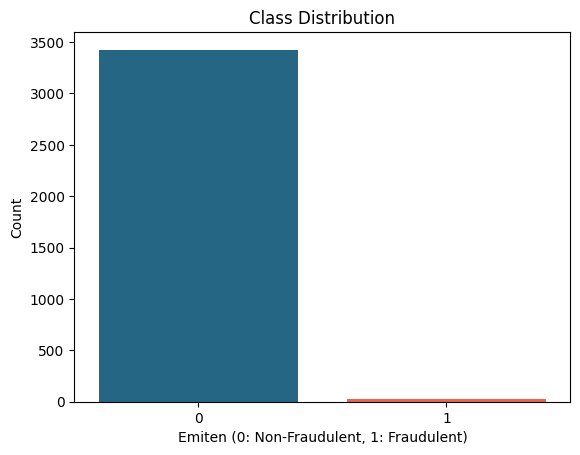

In [44]:
# Visualize Class Distribution
sns.countplot(x=fs_data_processed['emiten'], palette=['#146c94', '#ff5733'])
plt.title('Class Distribution')
plt.xlabel('Emiten (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

In [45]:
# Features and Target
X = fs_data_processed.drop(columns=['emiten'])
y = fs_data_processed['emiten']

In [46]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")
print(f"Training Labels Distribution:\n{Counter(y_train)}")
print(f"\nTest Labels Distribution:\n{Counter(y_test)}")


Training Set Shape: (2071, 14)
Test Set Shape: (1382, 14)
Training Labels Distribution:
Counter({0: 2055, 1: 16})

Test Labels Distribution:
Counter({0: 1371, 1: 11})


In [47]:
# Feature Scaling
scaler = MinMaxScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for better interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Handling Class Imbalance

C:\Users\User\AppData\Local\Temp\ipykernel_8008\580170197.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette=['#146c94', '#ff5733'])



Before Resampling:
Counter({0: 2055, 1: 16})


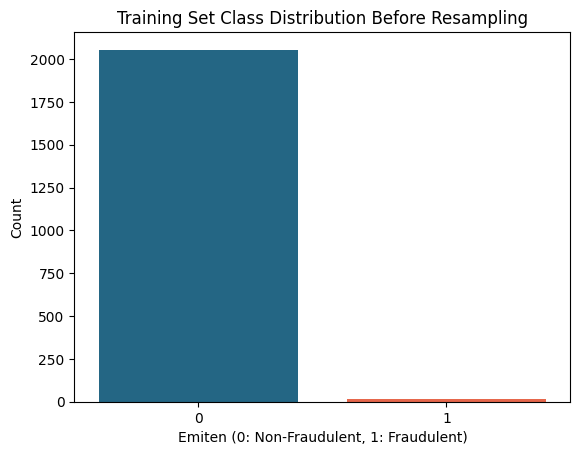

In [48]:
# Visualize Class Distribution Before Resampling
print("\nBefore Resampling:")
print(Counter(y_train))
sns.countplot(x=y_train, palette=['#146c94', '#ff5733'])
plt.title('Training Set Class Distribution Before Resampling')
plt.xlabel('Emiten (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

In [49]:
# Define Resampling Strategy
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
resampling_pipeline = ImbPipeline(steps=[('over', over), ('under', under)])

# Apply Resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)


After Resampling:
Counter({0: 410, 1: 205})


C:\Users\User\AppData\Local\Temp\ipykernel_8008\148845129.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette=['#146c94', '#ff5733'])


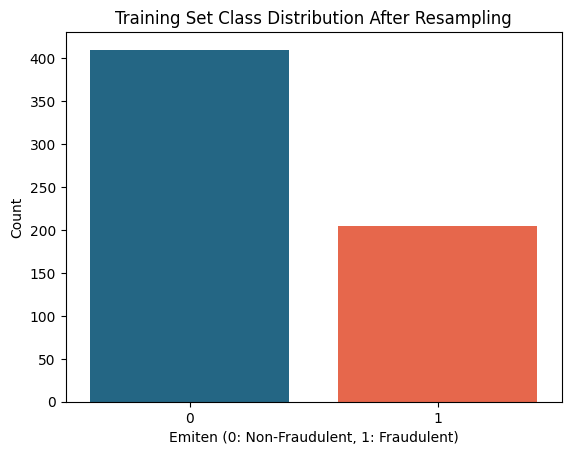

In [50]:
# Visualize Class Distribution After Resampling
print("\nAfter Resampling:")
print(Counter(y_resampled))
sns.countplot(x=y_resampled, palette=['#146c94', '#ff5733'])
plt.title('Training Set Class Distribution After Resampling')
plt.xlabel('Emiten (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

Hyperparameter Tuning

In [51]:
# Define Parameter Grid for RandomizedSearchCV
param_grid_random = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 1.5, 2.0],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}

In [54]:
# Initialize XGBoost Classifier
xgb_clf_random = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
)

In [55]:
# Initialize RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=xgb_clf_random,
    param_distributions=param_grid_random,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1',  # Suitable for imbalanced data
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Utilize all available cores
)

# Fit RandomizedSearchCV
print("\nStarting RandomizedSearchCV...")
rand_search.fit(X_resampled, y_resampled)


Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.1, 0.5, 1.0, 1.5, 2.0],
                                        'scale_pos_weight': [1, 2, 3, 4, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [56]:
# Best Parameters from RandomizedSearchCV
print("\nBest Hyperparameters from RandomizedSearchCV:")
print(rand_search.best_params_)

# Best Estimator
best_model_random = rand_search.best_estimator_


Best Hyperparameters from RandomizedSearchCV:
{'subsample': 0.6, 'scale_pos_weight': 3, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


Hyperparameter Tuning using Genetic Algorithm

In [57]:
# Define Parameter Grid for TPOT
param_grid_tpot = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}

In [58]:
# Initialize TPOTClassifier
tpot_clf = TPOTClassifier(
    generations=5,  # Number of iterations for the genetic algorithm
    population_size=20,  # Number of pipelines to keep in the population
    verbosity=2,
    random_state=42,
    config_dict={'xgboost.XGBClassifier': param_grid_tpot},
    scoring='f1',
    cv=5,
    n_jobs=-1,
    early_stop=10  # Stops if no improvement after 10 generations
)

# Fit TPOTClassifier
print("\nStarting TPOTClassifier...")
tpot_clf = tpot_clf.fit(X_resampled, y_resampled)


Starting TPOTClassifier...


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9312825079569255

Generation 2 - Current best internal CV score: 0.9312825079569255

Generation 3 - Current best internal CV score: 0.9312825079569255

Generation 4 - Current best internal CV score: 0.9339495798319326

Generation 5 - Current best internal CV score: 0.9339495798319326

Best pipeline: XGBClassifier(input_matrix, colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2, subsample=0.8)


In [59]:
# Best Pipeline from TPOT
best_pipeline_tpot = tpot_clf.fitted_pipeline_

# Extract Best Estimator (XGBClassifier) from TPOT Pipeline
best_model_tpot = best_pipeline_tpot.named_steps['xgbclassifier']

# Best Parameters from TPOT
print("\nBest Hyperparameters from TPOTClassifier:")
print(best_model_tpot.get_params())


Best Hyperparameters from TPOTClassifier:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.5, 'sampling_method': None, 'scale_pos_weight': 2, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Model Evaluation

In [60]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates the model on the test set and prints performance metrics.
    
    Parameters:
    - model: Trained machine learning model.
    - X_test: Scaled test features.
    - y_test: True labels for the test set.
    - model_name: Name of the model for display purposes.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall (Sensitivity): {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random chance
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


=== RandomizedSearchCV XGBClassifier Evaluation ===
Accuracy: 95.30%
Precision: 7.81%
Recall (Sensitivity): 45.45%
F1-Score: 13.33%
ROC-AUC: 0.90

Confusion Matrix:
[[1312   59]
 [   6    5]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1371
           1       0.08      0.45      0.13        11

    accuracy                           0.95      1382
   macro avg       0.54      0.71      0.55      1382
weighted avg       0.99      0.95      0.97      1382



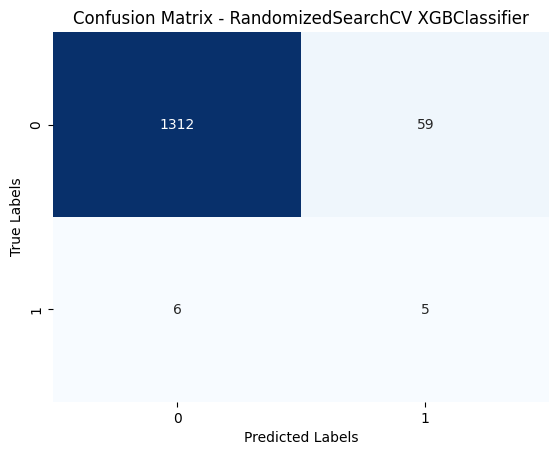

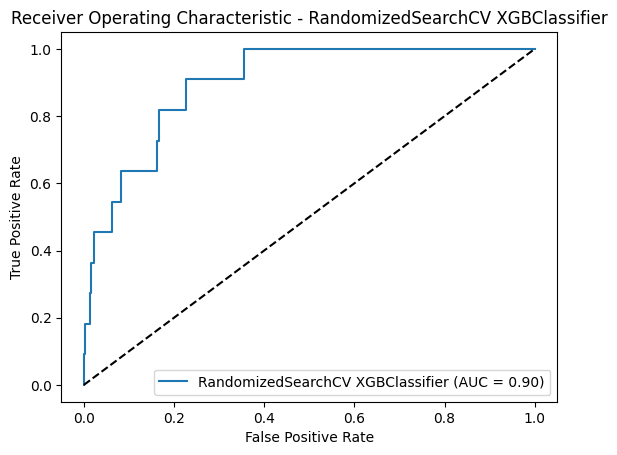

In [61]:
# Evaluate RandomizedSearchCV Best Model
evaluate_model(best_model_random, X_test_scaled, y_test, model_name="RandomizedSearchCV XGBClassifier")


=== TPOTClassifier XGBClassifier Evaluation ===
Accuracy: 95.51%
Precision: 5.26%
Recall (Sensitivity): 27.27%
F1-Score: 8.82%
ROC-AUC: 0.86

Confusion Matrix:
[[1317   54]
 [   8    3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1371
           1       0.05      0.27      0.09        11

    accuracy                           0.96      1382
   macro avg       0.52      0.62      0.53      1382
weighted avg       0.99      0.96      0.97      1382



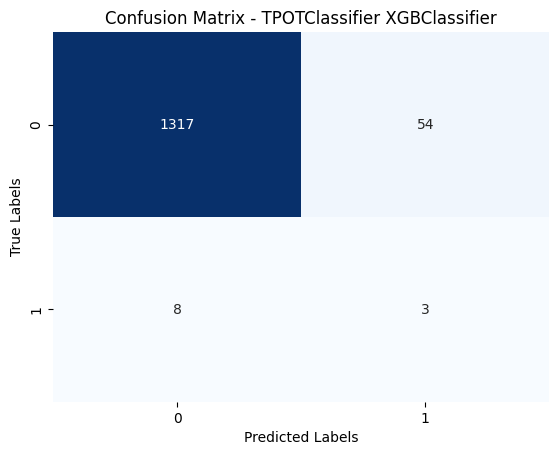

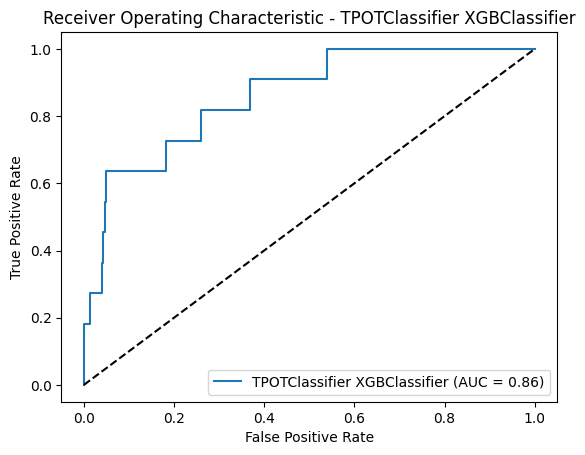

In [62]:
# Evaluate TPOTClassifier Best Model
evaluate_model(best_model_tpot, X_test_scaled, y_test, model_name="TPOTClassifier XGBClassifier")

Comparing Model

In [63]:
# Define a function to collect metrics
def collect_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }


In [64]:
# Collect metrics for both models
metrics_random = collect_metrics(best_model_random, X_test_scaled, y_test)
metrics_tpot = collect_metrics(best_model_tpot, X_test_scaled, y_test)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame([metrics_random, metrics_tpot], 
                             index=['RandomizedSearchCV XGB', 'TPOTClassifier XGB'])
print("\n=== Model Performance Comparison ===")
print(comparison_df)


=== Model Performance Comparison ===
                        Accuracy  Precision    Recall  F1-Score   ROC-AUC
RandomizedSearchCV XGB  0.952967   0.078125  0.454545  0.133333  0.899078
TPOTClassifier XGB      0.955137   0.052632  0.272727  0.088235  0.859558


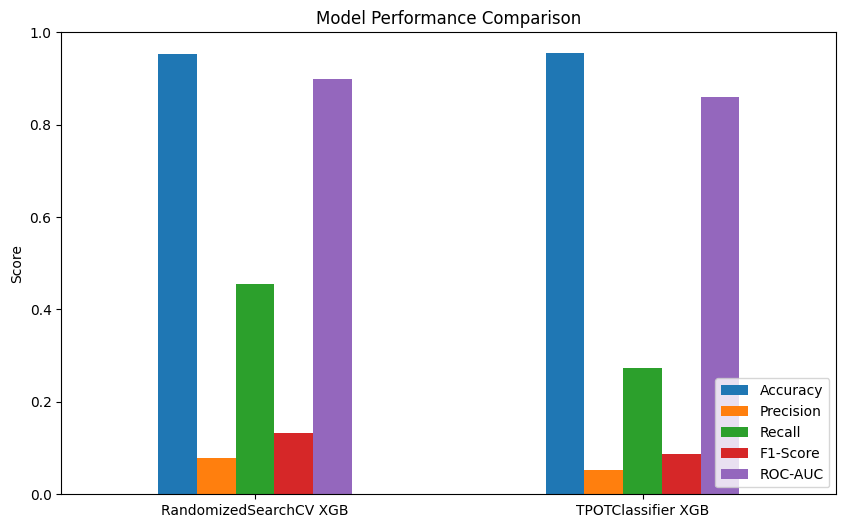

In [65]:
# Visualize Comparison
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

Feature Importance

In [66]:
# Feature Importance Plotting Function
def plot_feature_importance(model, feature_names, model_name="Model", top_n=20, normalize=False):
    """
    Plots the top_n feature importances of a trained XGBoost model.

    Parameters:
    - model: Trained XGBoost model.
    - feature_names: List of feature names.
    - model_name: Name of the model (for plot title).
    - top_n: Number of top features to display.
    - normalize: Boolean indicating whether to normalize importances.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract feature importances
    importances = model.feature_importances_
    
    if normalize:
        importances = importances / importances.sum()

    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # Select top_n features
    top_features = feature_importances[:top_n]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Normalized Importance Score' if normalize else 'Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [67]:
# Feature Importance Comparison Function
def compare_feature_importance(model1, model2, feature_names, model1_name="Model 1", model2_name="Model 2", top_n=20):
    """
    Compares feature importances from two trained XGBoost models.

    Parameters:
    - model1: First trained XGBoost model.
    - model2: Second trained XGBoost model.
    - feature_names: List of feature names.
    - model1_name: Name of the first model.
    - model2_name: Name of the second model.
    - top_n: Number of top features to display.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Extract feature importances
    importances1 = model1.feature_importances_
    importances2 = model2.feature_importances_

    feature_importances1 = pd.Series(importances1, index=feature_names).sort_values(ascending=False)[:top_n]
    feature_importances2 = pd.Series(importances2, index=feature_names).sort_values(ascending=False)[:top_n]

    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        model1_name: feature_importances1,
        model2_name: feature_importances2
    })

    # Plot
    comparison_df.plot(kind='bar', figsize=(14, 10))
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8008\407754748.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


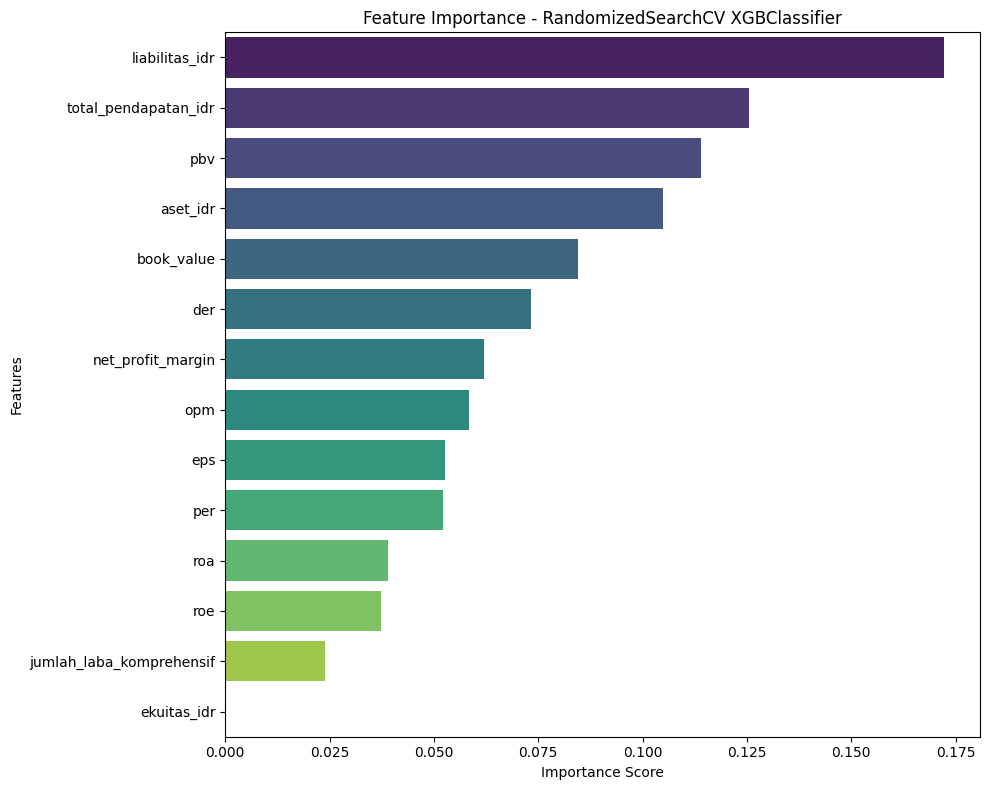

In [68]:
# Plot Feature Importance for RandomizedSearchCV Best Model
plot_feature_importance(
    model=best_model_random,
    feature_names=X.columns,
    model_name="RandomizedSearchCV XGBClassifier",
    top_n=20
)

C:\Users\User\AppData\Local\Temp\ipykernel_8008\407754748.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


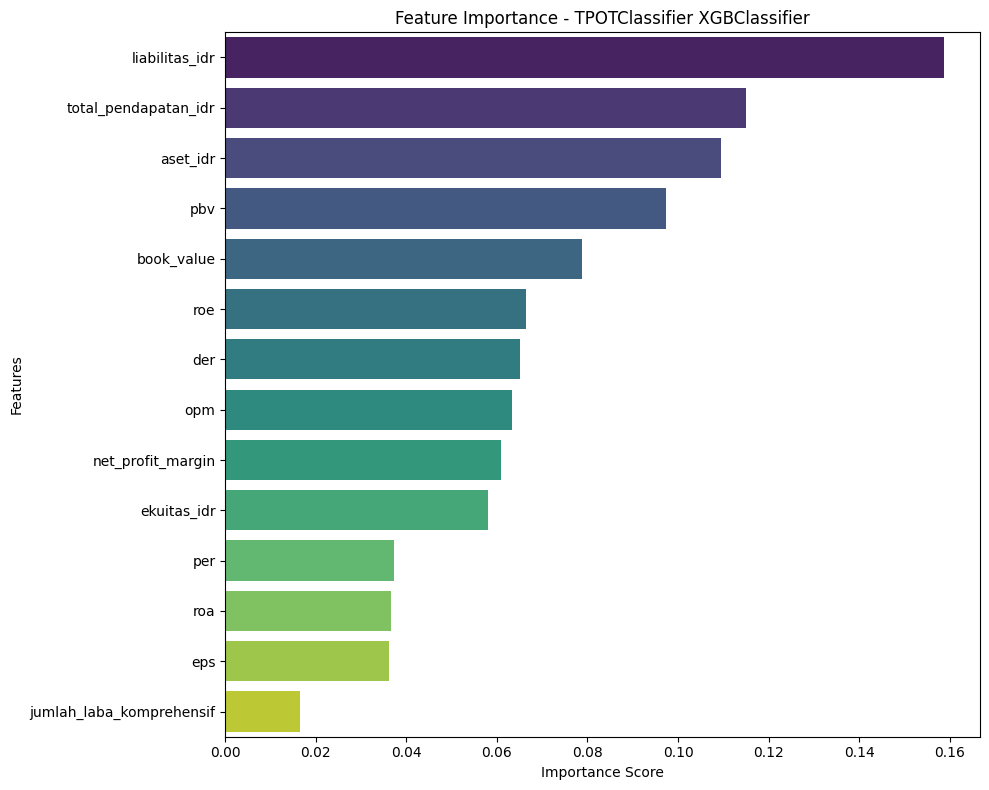

In [69]:
# Plot Feature Importance for TPOTClassifier Best Model
plot_feature_importance(
    model=best_model_tpot,
    feature_names=X.columns,
    model_name="TPOTClassifier XGBClassifier",
    top_n=20
)

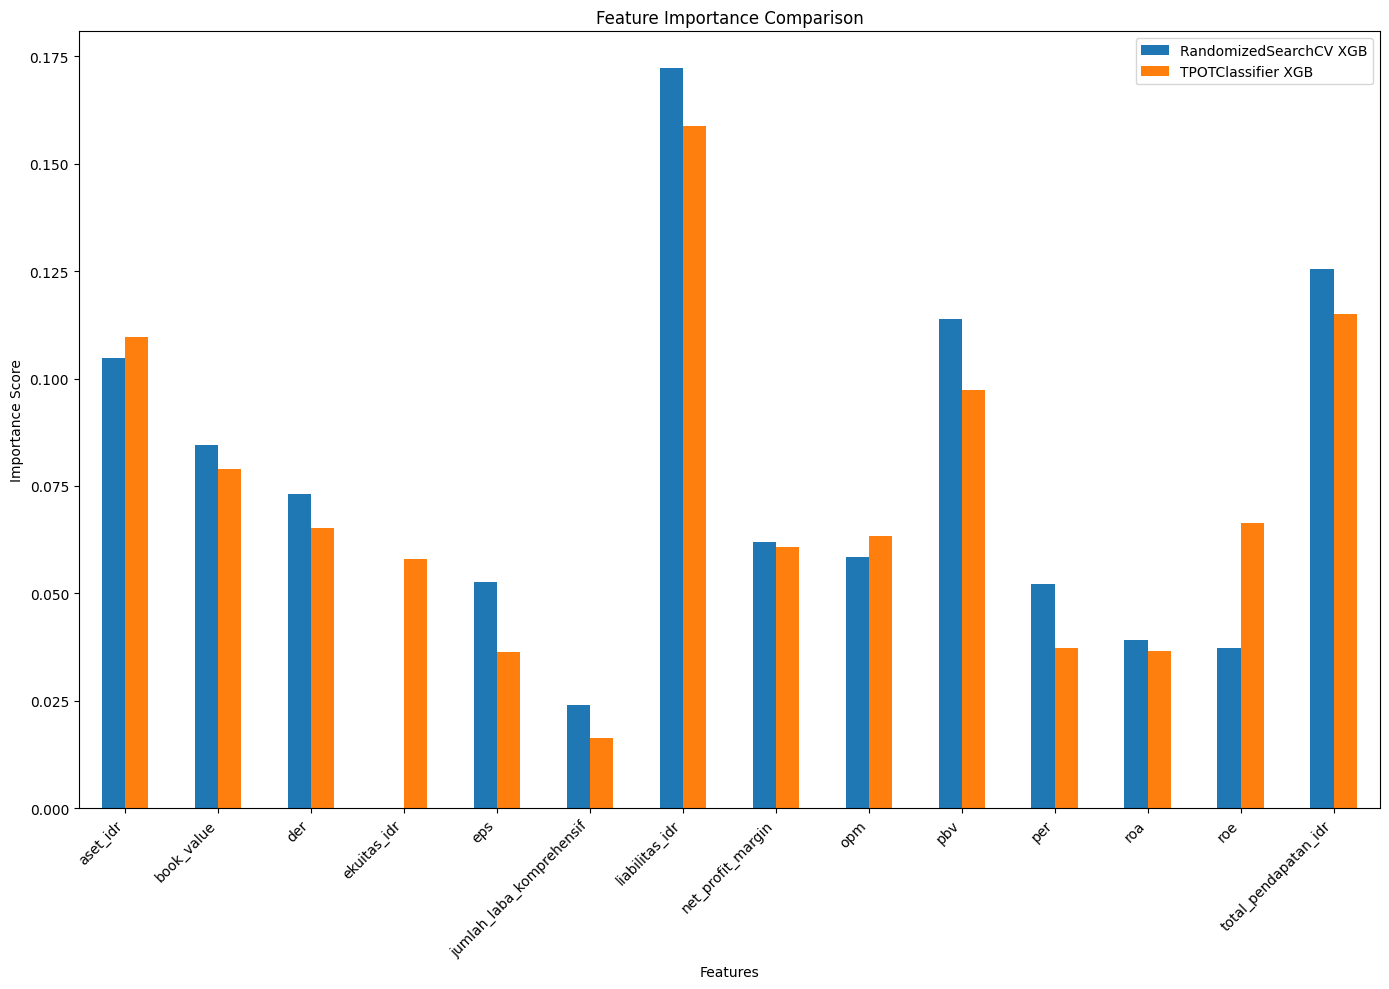

In [70]:
# Compare Feature Importance Between Both Models
compare_feature_importance(
    model1=best_model_random,
    model2=best_model_tpot,
    feature_names=X.columns,
    model1_name="RandomizedSearchCV XGB",
    model2_name="TPOTClassifier XGB",
    top_n=20
)

In [71]:
import shap

def shap_feature_importance(model, X, model_name="Model"):
    """
    Plots SHAP feature importances for a trained XGBoost model.

    Parameters:
    - model: Trained XGBoost model.
    - X: Feature DataFrame used for training.
    - model_name: Name of the model (for plot title).
    """
    # Initialize SHAP Explainer
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # Summary Plot
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()

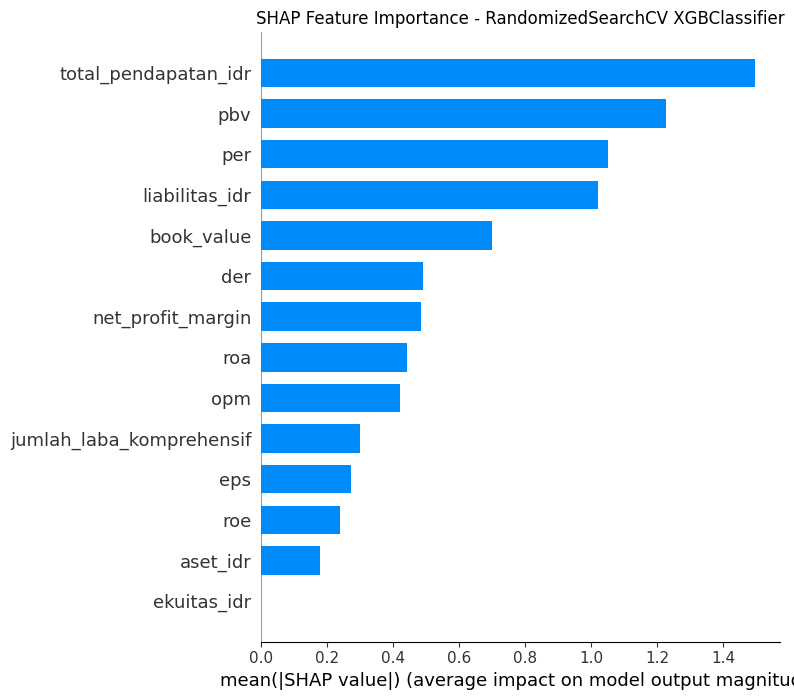

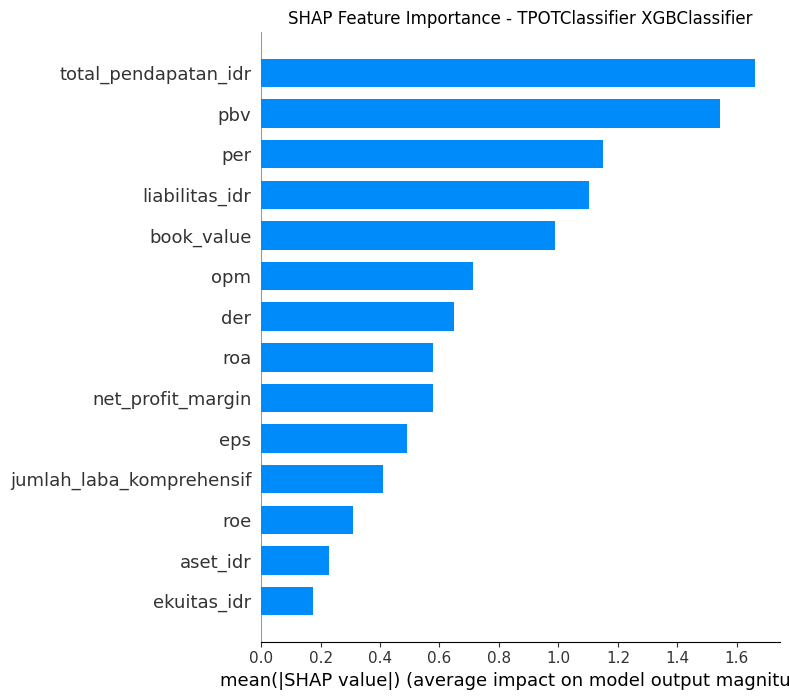

In [72]:
# SHAP Feature Importance for RandomizedSearchCV Best Model
shap_feature_importance(
    model=best_model_random,
    X=X_test_scaled,
    model_name="RandomizedSearchCV XGBClassifier"
)

# SHAP Feature Importance for TPOTClassifier Best Model
shap_feature_importance(
    model=best_model_tpot,
    X=X_test_scaled,
    model_name="TPOTClassifier XGBClassifier"
)
